[ 18994.  34565.  15233.  14376. 988433.  19493. 622093.  30483.  17165.
 233129.  61034.  23075. 723009.  38873.   4090.  34906.  69022. 339318.
 211895.  20189.  12218.]
[ 13332.282   27726.598   11212.124   11245.57   943637.2     15303.388
 589121.3     28175.037    8210.159  214212.25    57944.68    11201.357
 686195.2     24986.236    3096.6494  18233.947   49391.99   334717.25
 126612.33    11837.26    11386.689 ]
(DeviceArray([0.9950545 , 0.8463091 , 0.6699724 , 0.83133304, 0.8421058 ,
             0.8164508 , 0.99693674, 0.54721975, 0.78123564, 0.6399487 ,
             0.599912  , 0.28690797, 0.46837887, 0.43694586, 1.        ,
             1.        , 0.8909833 , 1.        , 0.9773342 , 0.93139154,
             0.9951883 ], dtype=float32), 21)


DeviceArray(0.78826714, dtype=float32)

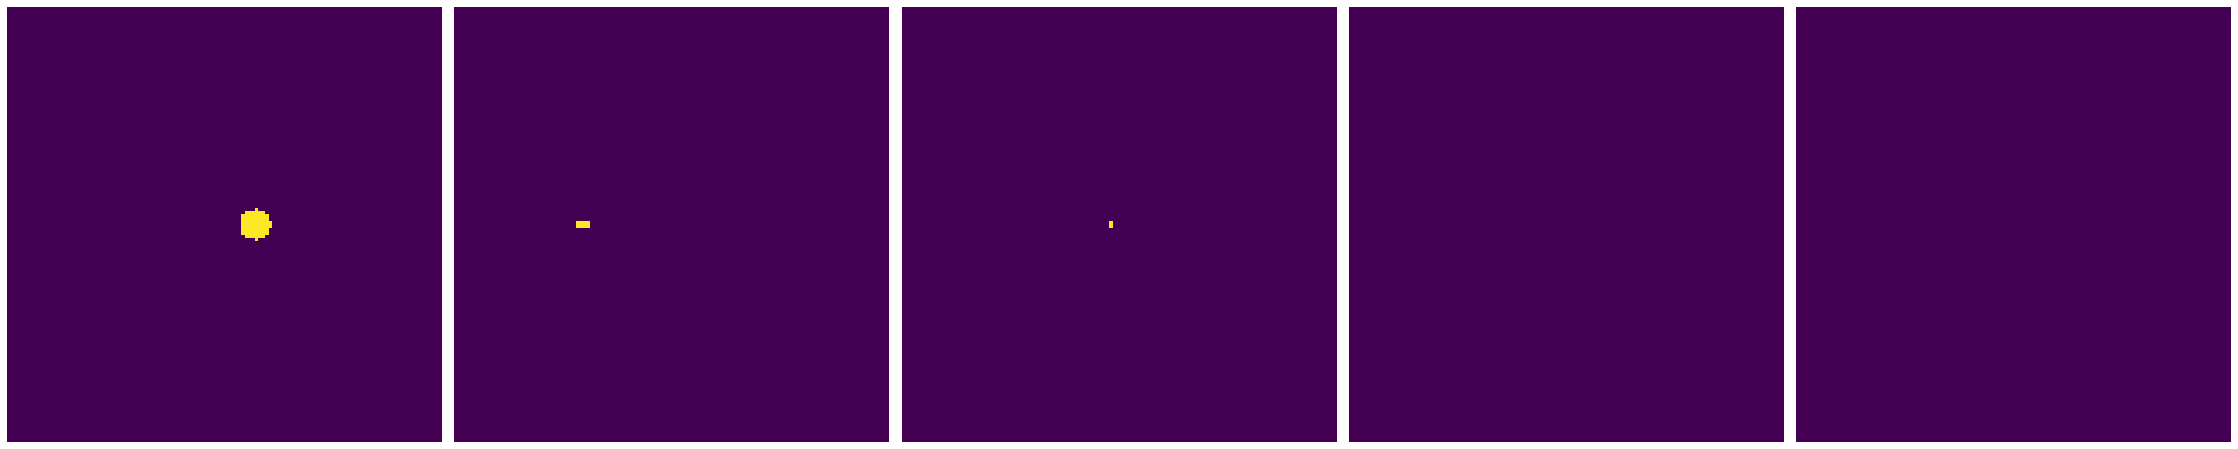

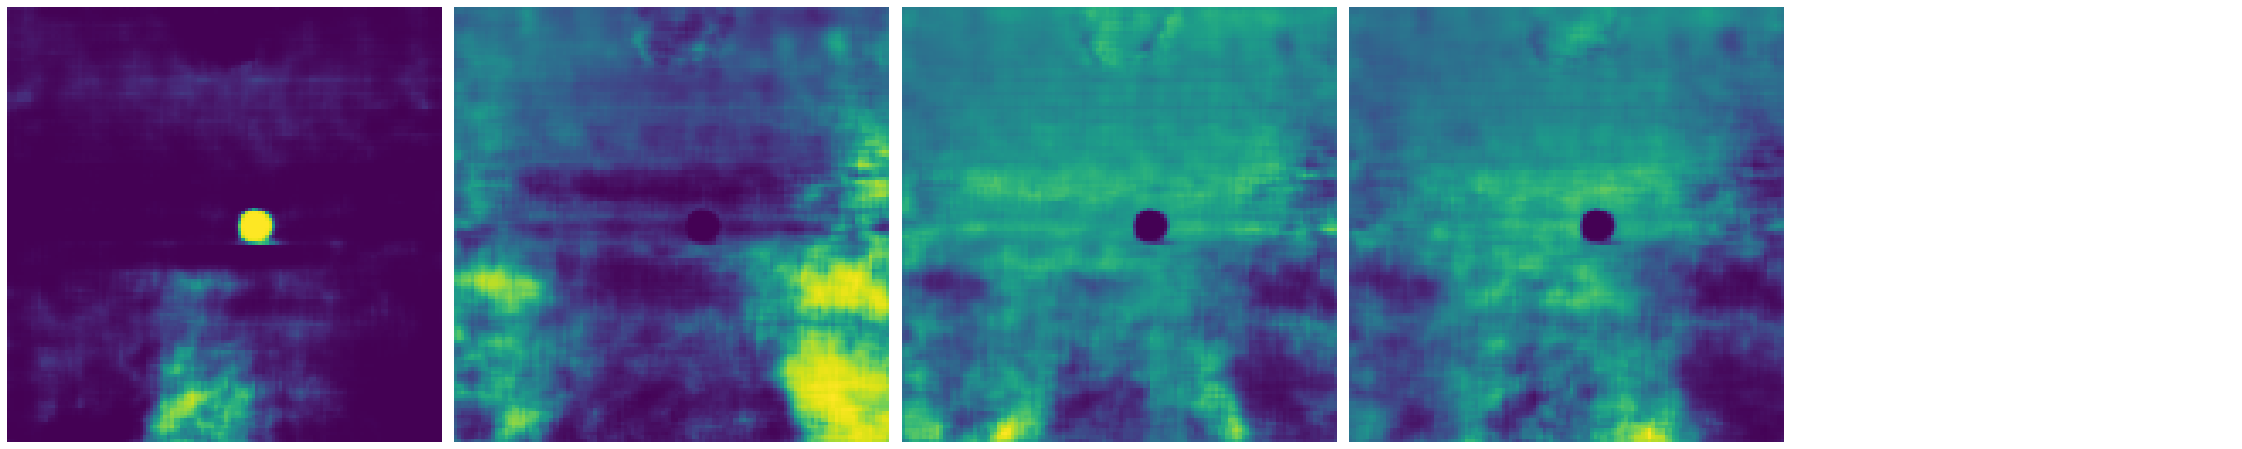

In [1]:
### Legacy file for visualizing ARI results ###


import os
import sys
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
import jax.numpy as jnp
import jax
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Local imports
from color_based_aai_mask_creator import get_ground_truth_masks
from ari_metric import mask_num_check, ari_score
from slot_attention_and_alignnet.src.dataloaders import DataController, DataLoader

BATCH_SIZE = 32
MAX_OBJECTS = 5

# d2 = DataController('/media/home/thomas/data', batch_size=1, test_train_split=0, file_name='aai_test', load_mode=True, shuffle=True, unbatch=False)
# val_ds = AAIDataLoader(d2, 1, "validation")
imgs = np.ceil(((np.load('test_input.npy') / 2.0) + 0.5) * 255.).astype(np.uint8) #np.array(next(val_ds))
unchecked_pred = np.load('test_alpha_masks.npy')
# unchecked_ground_truths = np.load('test_input_masks_sprite.npy')
unchecked_ground_truths = [get_ground_truth_masks(img, MAX_OBJECTS) for img in imgs]

# for m in unchecked_ground_truths:
#     m[-1] = np.logical_not(m[0]).astype(np.uint8)
unchecked_ground_truths = jnp.asarray(unchecked_ground_truths)

valid_indices = jnp.asarray(np.fromiter(map(mask_num_check, unchecked_ground_truths), dtype=bool))
pred_masks = unchecked_pred[valid_indices]
true_masks = unchecked_ground_truths[valid_indices]

ran = jnp.asarray(np.random.randint(2, size=((4, 128, 128, 1))))


def plot_skipped_images(skipped_images, columns, size):
    rows = math.ceil(len(skipped_images) / columns)
    f, ax = plt.subplots(rows, columns, figsize=(size * columns, size * rows))
    for i, axis in enumerate(ax.ravel()):
        axis.axis('off')
        if i < len(skipped_images):
            axis.imshow(skipped_images[i])
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show

a = jnp.asarray([true_masks[0][0]] + [true_masks[0][0]] + [true_masks[0][1]] + [jnp.sum(true_masks[0][:2], axis=0)])
# print(pred_masks[0][0].dtype)
# pred_masks[0][:, np.logical_not(jnp.sum(true_masks[0][:2], axis=0)).astype(bool)] = 0
# pred_masks[0] = np.array(pred_masks[0], dtype=np.float32)
# b = jnp.asarray([true_masks[0][3]] + [pred_masks[0][2]] + [pred_masks[0][3]])# + [pred_masks[0][2]])

plot_skipped_images(true_masks[14], 5, 8)
plot_skipped_images(pred_masks[14], 5, 8)


ari = ari_score(true_masks=true_masks, pred_masks=pred_masks, max_process=BATCH_SIZE)
print(ari)
jnp.mean(ari[0])